In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq
import math

# ==========================================
# 1. TẠO MẠNG LƯỚI & DỮ LIỆU (GIỮ NGUYÊN)
# ==========================================
width, height = 30, 30
G = nx.grid_2d_graph(width, height)

# Gán trọng số
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1.0

pos = {node: node for node in G.nodes()}

# Hàm sinh dữ liệu (Giữ nguyên)
def get_nearby_nodes(center_node, radius, count):
    candidates = []
    for node in G.nodes():
        dist = abs(node[0] - center_node[0]) + abs(node[1] - center_node[1])
        if dist <= radius:
            candidates.append(node)
    return random.sample(candidates, min(len(candidates), count))

# Tạo dữ liệu mẫu
data_nodes = []
# Cụm 1
data_nodes.extend(get_nearby_nodes((5, 5), radius=4, count=50))
# Cụm 2
data_nodes.extend(get_nearby_nodes((25, 25), radius=4, count=40))
# Cụm 3
data_nodes.extend(get_nearby_nodes((15, 15), radius=3, count=20))
# Nhiễu
all_nodes = list(G.nodes())
noise_points = random.sample(all_nodes, 40)
data_nodes.extend(noise_points)

# Xóa trùng lặp để mô phỏng clean data
data_nodes = list(set(data_nodes))
n_samples = len(data_nodes)

print(f"Tổng số điểm dữ liệu: {n_samples}")

Tổng số điểm dữ liệu: 135


In [2]:
# ==========================================
# 2. CÀI ĐẶT 3 THUẬT TOÁN CẢI TIẾN
# ==========================================

# --- CẢI TIẾN A: ALGO 1 (LSPD) ---
# Mục tiêu: Tìm hàng xóm trong bán kính Eps nhanh nhất có thể
def get_network_neighbors_optimized(G_pruned, start_node, eps):
    distances = {start_node: 0}
    queue = [(0, start_node)] # Priority Queue cho Dijkstra
    neighbors = []

    while queue:
        current_dist, u = heapq.heappop(queue)

        # CẢI TIẾN 2: Dừng ngay khi chạm ngưỡng (>= thay vì >)
        if current_dist > eps:
            continue
        
        # Nếu điểm này là một điểm dữ liệu (có trong tập data), thêm vào neighbors
        # (Lưu ý: start_node cũng được tính là neighbor của chính nó trong định nghĩa DBSCAN)
        if u in data_set_lookup: 
            neighbors.append(u)

        # Duyệt hàng xóm trên đồ thị ĐÃ ĐƯỢC CẮT TỈA (G_pruned)
        for v in G_pruned.neighbors(u):
            weight = G_pruned[u][v]['weight']
            new_dist = current_dist + weight
            
            if new_dist <= eps: # Chỉ mở rộng nếu vẫn trong tầm với
                if new_dist < distances.get(v, float('inf')):
                    distances[v] = new_dist
                    heapq.heappush(queue, (new_dist, v))
    return neighbors

# --- HÀM CHÍNH: NS-DBSCAND ---
def run_ns_dbscand(G, data_points, eps, min_pts):
    global data_set_lookup
    data_set_lookup = set(data_points) # Hash set để tra cứu nhanh O(1)
    
    # --- CẢI TIẾN 1: Cắt tỉa đồ thị ngay từ đầu ---
    # Loại bỏ tất cả cạnh > eps (Ở đây cạnh nào cũng = 1, eps=1.5 nên giữ hết)
    # Nhưng nếu mạng lưới thực tế có cạnh dài, bước này cực lợi.
    valid_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= eps]
    G_pruned = nx.Graph()
    G_pruned.add_nodes_from(G.nodes())
    G_pruned.add_edges_from(valid_edges)
    # Copy trọng số sang graph mới
    for u, v, d in G.edges(data=True):
        if d['weight'] <= eps:
            G_pruned[u][v]['weight'] = d['weight']

    # --- CẢI TIẾN B: ALGO 2 (Tạo bảng mật độ) ---
    print("Đang tính toán mật độ và sắp xếp...")
    ordered_list = []
    
    # CẢI TIẾN 4: Ngưỡng lọc mật độ thấp (Heuristic ln(n))
    # Ví dụ: ln(150) ~ 5. Nếu mật độ < 5 -> Loại luôn, coi là nhiễu ngay.
    density_threshold = math.log(len(data_points)) 
    print(f"Ngưỡng mật độ Heuristic (ln(n)): {density_threshold:.2f}")

    point_neighbors_cache = {} # Lưu lại để Algo 3 dùng, đỡ tính lại

    for p in data_points:
        # Gọi Algo 1 để tìm hàng xóm
        nbrs = get_network_neighbors_optimized(G_pruned, p, eps)
        density = len(nbrs)
        
        # CẢI TIẾN 4: Loại bỏ điểm mật độ thấp
        if density >= density_threshold:
             ordered_list.append((density, p))
             point_neighbors_cache[p] = nbrs # Cache lại kết quả
        # Nếu nhỏ hơn threshold, p bị bỏ qua (sẽ tự động thành Noise sau này)

    # CẢI TIẾN 3: Sắp xếp giảm dần theo mật độ
    # (Python sort dùng Timsort, rất tối ưu cho việc này)
    ordered_list.sort(key=lambda x: x[0], reverse=True)
    
    # --- CẢI TIẾN C: ALGO 3 (Hình thành cụm) ---
    print("Đang gom cụm...")
    labels = {} # Dict lưu kết quả: {node: cluster_id}
    cluster_id = 0
    
    for density, p in ordered_list:
        # CẢI TIẾN 6: Bỏ qua kiểm tra nhiễu, chỉ check đã visited chưa
        if p in labels:
            continue
            
        # Lấy hàng xóm từ cache
        neighbors = point_neighbors_cache[p]
        
        if len(neighbors) >= min_pts:
            # Tìm thấy điểm lõi mới -> Tạo cụm mới
            cluster_id += 1
            labels[p] = cluster_id
            
            # Mở rộng cụm (Expand Cluster)
            seeds = list(neighbors)
            i = 0
            while i < len(seeds):
                q = seeds[i]
                
                # CẢI TIẾN 5: Bỏ qua xác định Nhiễu rõ ràng
                # Nếu q chưa có nhãn -> Gán vào cụm hiện tại
                if q not in labels:
                    labels[q] = cluster_id
                    
                    # Nếu q cũng là điểm lõi (đủ mật độ), nạp hàng xóm của nó vào seeds
                    # Lưu ý: Cần tính lại hàng xóm cho q vì q có thể chưa được tính ở bước Algo 2 (do mật độ thấp)
                    if q in point_neighbors_cache:
                        q_neighbors = point_neighbors_cache[q]
                    else:
                        q_neighbors = get_network_neighbors_optimized(G_pruned, q, eps)
                    
                    if len(q_neighbors) >= min_pts:
                        seeds.extend(q_neighbors)
                
                # Nếu q đã có nhãn là Noise (từ trước), DBSCAN gốc sẽ đổi thành Border.
                # Nhưng logic cải tiến bảo "bỏ qua check nhiễu", cứ chưa có label thì gán.
                
                i += 1
    
    return labels

In [3]:
# ==========================================
# 3. CHẠY THUẬT TOÁN
# ==========================================
# Cấu hình tham số
EPS = 1.5       # Bán kính mạng lưới
MIN_PTS = 4     # Mật độ tối thiểu

# Chạy NS-DBSCAND
# Kết quả trả về là một Dictionary: {Tọa độ điểm: ID Cụm}
# Những điểm không có trong dict này chính là NHIỄU
labels_dict = run_ns_dbscand(G, data_nodes, EPS, MIN_PTS)

print(f"\nĐã phân cụm xong!")
print(f"Số lượng điểm được gán vào cụm: {len(labels_dict)}/{n_samples}")

Đang tính toán mật độ và sắp xếp...
Ngưỡng mật độ Heuristic (ln(n)): 4.91
Đang gom cụm...

Đã phân cụm xong!
Số lượng điểm được gán vào cụm: 103/135


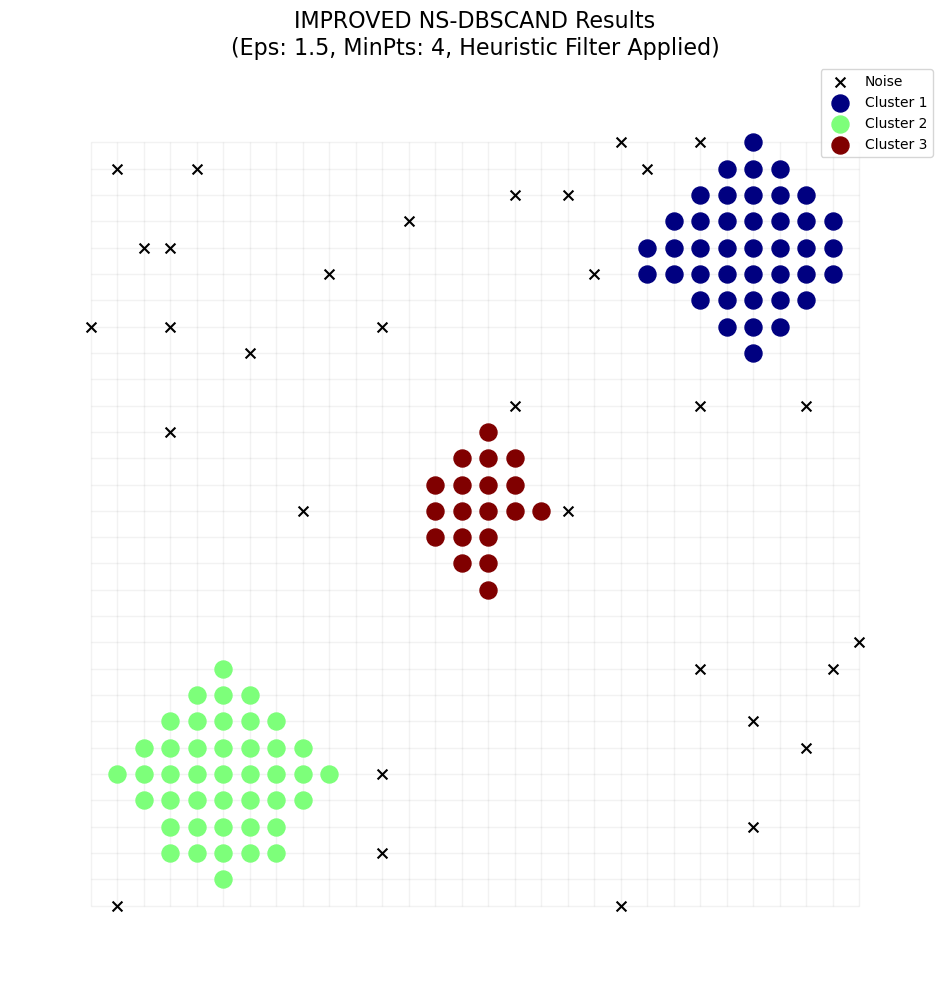

In [4]:
# ==========================================
# 4. VẼ KẾT QUẢ
# ==========================================
plt.figure(figsize=(12, 12))

# Vẽ nền bản đồ mờ
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# Chuẩn bị dữ liệu vẽ
# Tách các điểm thành từng nhóm dựa trên ID cụm
clusters = {} # {cluster_id: [list of nodes]}
noise_nodes = []

for node in data_nodes:
    if node in labels_dict:
        c_id = labels_dict[node]
        if c_id not in clusters:
            clusters[c_id] = []
        clusters[c_id].append(node)
    else:
        # Nếu không có trong labels_dict -> Là NHIỄU (do Cải tiến 5 & 6)
        noise_nodes.append(node)

# Tạo bảng màu
unique_cluster_ids = list(clusters.keys())
colors = plt.cm.jet(np.linspace(0, 1, len(unique_cluster_ids)))

# 1. Vẽ Nhiễu (Noise)
if noise_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=noise_nodes, 
                           node_color='black', node_size=50, node_shape='x', label='Noise')

# 2. Vẽ các Cụm
for i, c_id in enumerate(unique_cluster_ids):
    nodes = clusters[c_id]
    col = colors[i]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                           node_color=[col], node_size=150, node_shape='o', label=f'Cluster {c_id}')

plt.title(f"IMPROVED NS-DBSCAND Results\n(Eps: {EPS}, MinPts: {MIN_PTS}, Heuristic Filter Applied)", fontsize=16)
plt.legend()
plt.axis('off')
plt.show()